# Analyze simulated 4-D CO2 fields

Gretchen Keppel-Aleks

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pandas as pd

#### load time series of some relevant variables from the HOPE ensemble

##### Data is located here: /glade/campaign/cesm/community/bgcwg/HOPE


There are several experiments, each with several ensemble members:  
b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001

b.e21.BSSP119.f09_g17.hopens-reference.esmfirebvoc.001

b.e21.BSSP245.f09_g17.hopens-reference.esmfirebvoc.001

b.e21.BSSP370.f09_g17.hopens-reference.esmfirebvoc.001




In [2]:
# data location on campaign
datapath = '/glade/campaign/cesm/community/bgcwg/HOPE/'

# list of all unique case types, each with 3 or 5 ensemble members
casenamelist=['b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.00',
              'b.e21.BSSP119.f09_g17.hopens-reference.esmfirebvoc.00',
              'b.e21.BSSP245.f09_g17.hopens-reference.esmfirebvoc.00',
              'b.e21.BSSP370.f09_g17.hopens-reference.esmfirebvoc.00']

shortnames=['BHIST','BSSP119','BSSP245','BSSP370'] # short names that are more suitable for displaying on plots
ensnumlist = [4,4,4,2] # list of how many ensemble members for each experiment, indexed from zero

colorlist = ['black','#00a9cf','#f69320','#df0000'] # specify the colors associated with these SSPs

# example of how to select a single ensemble member
ensm=0
c=0
casename = casenamelist[c] +str(ensm+1)
casenameshort = shortnames[c] +str(ensm+1)

print('casename = ' +casename)

# or just specify the whole name
#casename = 'b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.003'


casename = b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001


#### Some releavant atmospheric carbon variables

- CO2 = sum of Fossil (FF), terrestrial (LND), and ocean (OCN) carbon 
- CO2_FF = Fossil CO2 from emissions file  
- CO2_LND = CO2 from terrestrial sources  
- CO2_OCN = CO2 from ocean sources  

The above are 4-D fields (lat, lon, pressure, time)

- SFCO2 is a 3-D field, at only the atmospheric layer adjacent to the land or ocean surface


In [3]:
# this list is repeated farther down when data is loaded. You can add any atmospheric variables here
varlist = ['CO2', 'CO2_FF', 'CO2_LND', 'CO2_OCN']

## Load Data

#### for a single ensemble member

In [4]:
# example of how to select a single ensemble member
ensm=0
c=0
casename = casenamelist[c] +str(ensm+1)
casenameshort = shortnames[c] +str(ensm+1)

print('casename = ' +casename)

casename = b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001


In [5]:
# example to load one ensemble member into dataset called ds_r

# to load multiple variables you can use xarray's open_mfdataset
# you probably don't want to load them all, but you can select a subset of variabiles like this

varlist = ['CO2', 'CO2_FF', 'CO2_LND', 'CO2_OCN', 'PS']
filenamelist=[]

for v in range(len(varlist)):
    var=varlist[v]
    filenames = glob.glob(datapath + casename +'/atm/proc/tseries/month_1/*.' +var +'.*.nc')

    filenamelist=filenamelist+filenames

print(filenamelist)

#open all of the files in filenamelist into on xarray dataset named ds_r
ds_r = xr.open_mfdataset(filenamelist)


['/glade/campaign/cesm/community/bgcwg/HOPE/b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001/atm/proc/tseries/month_1/b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001.cam.h0.CO2.185001-201412.nc', '/glade/campaign/cesm/community/bgcwg/HOPE/b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001/atm/proc/tseries/month_1/b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001.cam.h0.CO2_LND.185001-201412.nc', '/glade/campaign/cesm/community/bgcwg/HOPE/b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001/atm/proc/tseries/month_1/b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001.cam.h0.CO2_OCN.185001-201412.nc', '/glade/campaign/cesm/community/bgcwg/HOPE/b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001/atm/proc/tseries/month_1/b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001.cam.h0.PS.185001-201412.nc']


In [6]:
def calc_pressure(ds_r):
    #This function calculates atmospheric pressure using the 3-D surface pressure (PS(x,y,t)) and the vectors hyam and hybm
    #This gives us pressure at the midpoints of the atmospheric layers
    dims=ds_r.dims

    hyam=ds_r['hyam'].expand_dims(dim={'time':dims['time'], 'lat':dims['lat'], 'lon':dims['lon']}, axis=(0,2,3))
    hybm=ds_r['hybm'].expand_dims(dim={'time':dims['time'], 'lat':dims['lat'], 'lon':dims['lon']}, axis=(0,2,3))
    PS=ds_r['PS'].expand_dims(dim={ 'lev':dims['lev']}, axis=(1))
    
    P0= float(ds_r['P0'])
    #p(k) = a(k)*p0 + b(k)*ps.
    P=hyam*P0+hybm*PS
    return P

#returns pressure in units of [Pa]

In [7]:
Patm=calc_pressure(ds_r)

Patm

<xarray.DataArray (time: 1980, lev: 32, lat: 192, lon: 288)> Size: 28GB
dask.array<add, shape=(1980, 32, 192, 288), dtype=float64, chunksize=(1, 32, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 16kB 1850-02-01 00:00:00 ... 2015-01-01 00:00:00

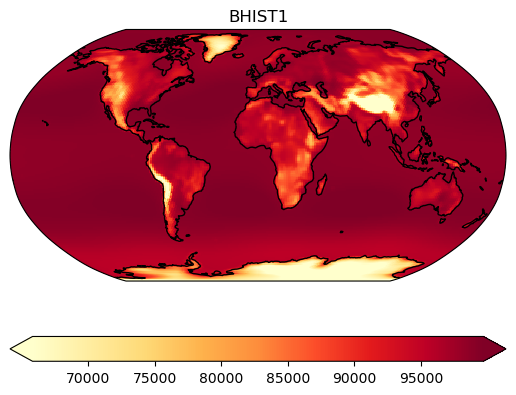

In [8]:
# make a map of the avearge in time
levno = 30 # pick an arbitrary level and see what the pressure looks like! pressure increases with lev

fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Robinson()))

data_to_plot = Patm.mean(dim='time').isel(lev=levno)

# to deal with outlier points, set max and min values using percentiles
max_ = np.nanpercentile(data_to_plot, 96)
min_ = np.nanpercentile(data_to_plot, 4)

# plot map using xarray
data_to_plot.plot(ax=axis,transform=ccrs.PlateCarree(), 
                                cbar_kwargs={'orientation': 'horizontal'},
                                cmap='YlOrRd', vmin=min_, vmax=max_)

plt.title(casenameshort) # add a title

axis.coastlines()  # cartopy function

#### Select one variable to look at 

In [9]:
ds = ds_r
var='CO2'
# units are kg/kg
# We will need to apply unit conversions since atmospheric CO2 is usually reported in ppm (mol per 10^6 mol)
mass2mol=29/44
frac2ppm=10**6

#specify the location of CO2 observing site at MLO
MLOlat=19.47
MLOlon=360-155.6
MLOpres=68000

In [10]:
#first, figure out what level is closest to the MLO pressure
Patm_MLO=Patm.sel(lat=MLOlat, method='nearest').sel(lon=MLOlon, method='nearest').mean('time')

MLOlev=np.where(Patm_MLO>MLOpres)[0][0]
print(MLOlev)

22


Text(0, 0.5, 'CO2 [ppm]')

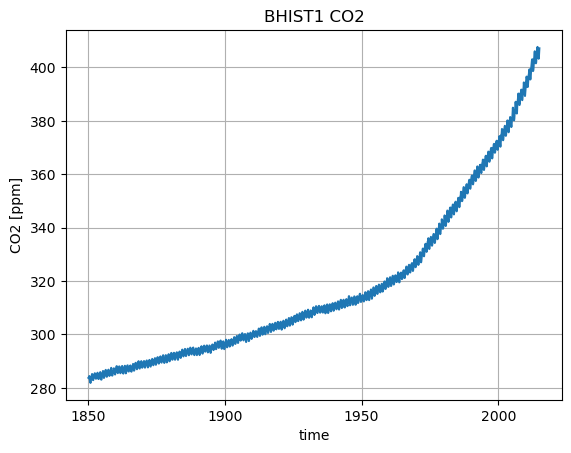

In [11]:
# Plot a timeseries of surface CO2 at Mauna Loa
fig, axis=plt.subplots(1,1)

data_to_plot=ds_r[var].isel(lev=MLOlev).sel(lat=MLOlat, method='nearest').sel(lon=MLOlon, method='nearest')*mass2mol*frac2ppm
data_to_plot.plot()
plt.title(casenameshort +' ' +var )
plt.grid()
plt.ylabel(var + ' [ppm]')

Text(0, 0.5, 'CO2 [ppm]')

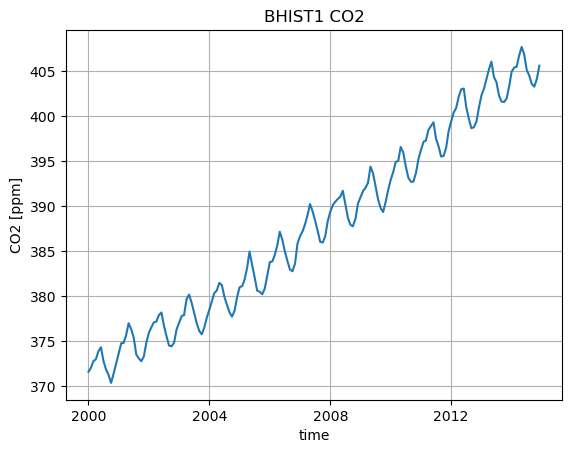

In [12]:
#zoom in on most recent data-- it can be hard to detrend an exponentially increasing function,
# especially if you want to look at interannually varying anomalies


end_run = ds_r[var].sel(
    time=slice('2000-01-01', '2014-12-01'))

data_to_plot=end_run.isel(lev=MLOlev).sel(lat=MLOlat, method='nearest').sel(lon=MLOlon, method='nearest')*mass2mol*frac2ppm
data_to_plot.plot()
plt.title(casenameshort +' ' +var )
plt.grid()
plt.ylabel(var + ' [ppm]')


In [13]:
def detrend_dim(da, dim, deg):
    # this function will detrend the CO2 data to enable analysis of mean annual cycle or growth rate anomalies
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

Text(0, 0.5, 'CO2 [ppm]')

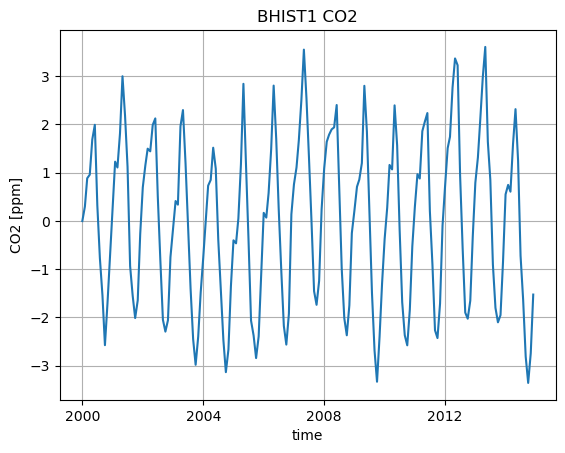

In [14]:
detrended=detrend_dim(end_run, 'time', 2) #2nd order polynomial
meancycle=detrended.groupby('time.month').mean('time')

data_to_plot=detrended.isel(lev=MLOlev).sel(lat=MLOlat, method='nearest').sel(lon=MLOlon, method='nearest')*mass2mol*frac2ppm
data_to_plot.plot()
plt.title(casenameshort +' ' +var )
plt.grid()
plt.ylabel(var + ' [ppm]')



Text(0, 0.5, 'CO2 [ppm]')

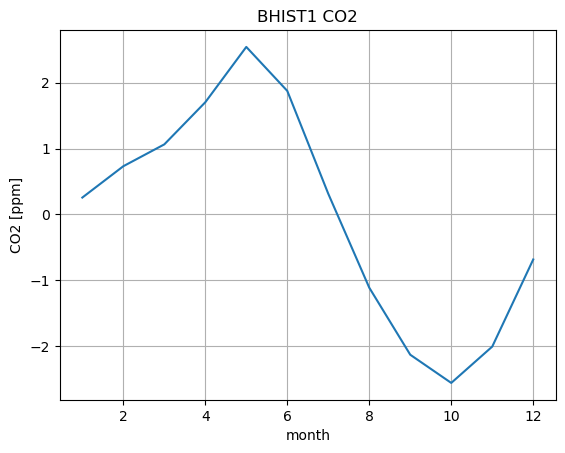

In [15]:
data_to_plot=meancycle.isel(lev=MLOlev).sel(lat=MLOlat, method='nearest').sel(lon=MLOlon, method='nearest')*mass2mol*frac2ppm
data_to_plot.plot()
plt.title(casenameshort +' ' +var )
plt.grid()
plt.ylabel(var + ' [ppm]')

## Plot a map showing spatial average of last 15 years
## Why are the values so high over areas of active biospheric exchange??

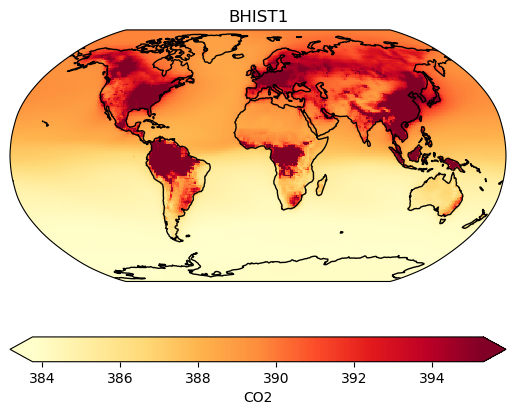

In [16]:
# make a map of the avearge in time
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Robinson()))

data_to_plot = end_run.mean(dim='time').isel(lev=31)*mass2mol*frac2ppm

# to deal with outlier points, set max and min values using percentiles
max_ = np.nanpercentile(data_to_plot, 96)
min_ = np.nanpercentile(data_to_plot, 4)

# plot map using xarray
data_to_plot.plot(ax=axis,transform=ccrs.PlateCarree(), 
                                cbar_kwargs={'orientation': 'horizontal'},
                                cmap='YlOrRd', vmin=min_, vmax=max_)

plt.title(casenameshort) # add a title

axis.coastlines()  # cartopy function

## Calculate  total column average mole fraction
#### This is what satellites like OCO-2 measure from space

In [17]:
def calc_pressure_bnds(ds_r):
    # Here, we are calculating pressure at the level interfaces
    # necessary so we can take the difference and pressure-weight CO2 in each level
    dims=ds_r.dims

    hyai=ds_r['hyai'].expand_dims(dim={'time':dims['time'], 'lat':dims['lat'], 'lon':dims['lon']}, axis=(0,2,3))
    hybi=ds_r['hybi'].expand_dims(dim={'time':dims['time'], 'lat':dims['lat'], 'lon':dims['lon']}, axis=(0,2,3))
    PS=ds_r['PS'].expand_dims(dim={ 'ilev':dims['ilev']}, axis=(1))
    
    P0= float(ds_r['P0'])
    #p(k) = a(k)*p0 + b(k)*ps.
    Pbnds=hyai*P0+hybi*PS
    return Pbnds

#returns pressure in units of [Pa]

In [18]:
Pbnds=calc_pressure_bnds(ds_r)

Pbnds
# Notice that the dimensions are still "ilev" rather than "lev"
# We will have to take care of this before we can multiply with CO2

<xarray.DataArray (time: 1980, ilev: 33, lat: 192, lon: 288)> Size: 29GB
dask.array<add, shape=(1980, 33, 192, 288), dtype=float64, chunksize=(1, 33, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * ilev     (ilev) float64 264B 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 16kB 1850-02-01 00:00:00 ... 2015-01-01 00:00:00

In [19]:
def integrate_column(ds_r, var, Pbnds):
    # this function returns the pressure-weighted mole fraction
    # also known as the vertically integrated mole fraction
    # also known as XCO2
    deltaP=Pbnds.diff(dim='ilev')
    dP = deltaP.rename({'ilev':'lev'}).assign_coords({'lev':ds_r[var].lev})
    #need to rename the dimension "ilev" to "lev" and assign coordinates appropriately
    #before multiplying dP by our carbon variable of interest
    PxC=dP*ds_r[var]
    XCO2=PxC.sum(dim='lev')/dP.sum(dim='lev')
    return XCO2

In [20]:
XCO2 =integrate_column(ds_r, 'CO2', Pbnds)

Text(0, 0.5, 'CO2 [ppm]')

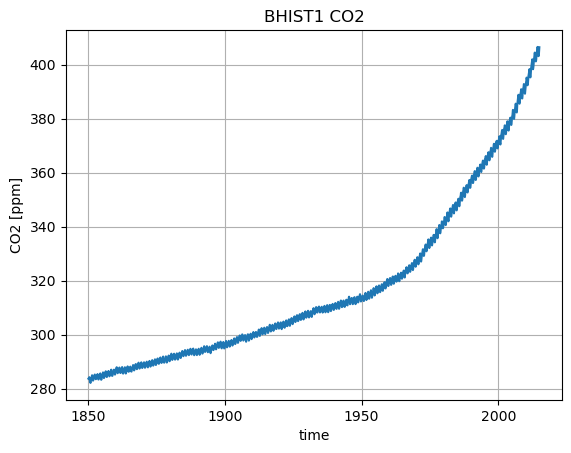

In [21]:
# Plot a timeseries of CO2 at Mauna Loa
fig, axis=plt.subplots(1,1)

data_to_plot=XCO2.sel(lat=MLOlat, method='nearest').sel(lon=MLOlon, method='nearest')*mass2mol*frac2ppm
data_to_plot.plot()
plt.title(casenameshort +' ' +var )
plt.grid()
plt.ylabel(var + ' [ppm]')

Text(0, 0.5, 'CO2 [ppm]')

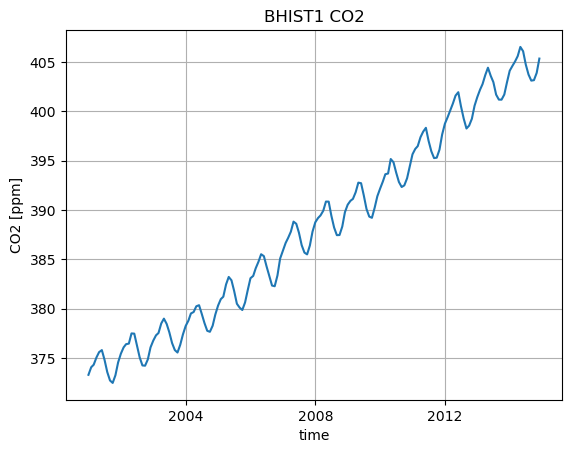

In [22]:
end_runXCO2 = XCO2.sel(
    time=slice('2001-01-01', '2014-12-01'))

data_to_plot=end_runXCO2.sel(lat=MLOlat, method='nearest').sel(lon=MLOlon, method='nearest')*mass2mol*frac2ppm
data_to_plot.plot()
plt.title(casenameshort +' ' +var )
plt.grid()
plt.ylabel(var + ' [ppm]')


In [23]:
end_runXCO2 = XCO2.sel(
    time=slice('2000-01-01', '2014-12-01'))

data_to_plot=end_runXCO2.sel(lat=MLOlat, method='nearest').sel(lon=MLOlon, method='nearest')*mass2mol*frac2ppm


Text(0, 0.5, 'CO2 [ppm]')

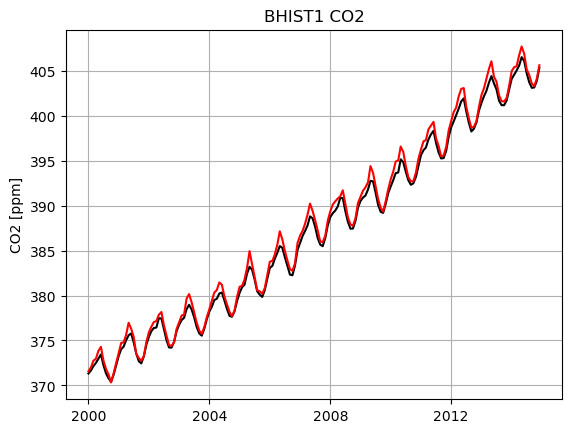

In [24]:
plt.figure()
plt.plot(data_to_plot.time, data_to_plot, 'k-')
sfcdata_to_plot=end_run.isel(lev=MLOlev).sel(lat=MLOlat, method='nearest').sel(lon=MLOlon, method='nearest')*mass2mol*frac2ppm
plt.plot(sfcdata_to_plot.time, sfcdata_to_plot, 'r-')
plt.title(casenameshort +' ' +var )
plt.grid()
plt.ylabel(var + ' [ppm]')